In [1]:
import os
import pickle
import random
from os.path import join
from tifffile import imread
from pathlib import Path

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.path import Path as mplPath
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

tqdm.pandas()

from scipy.ndimage import gaussian_filter1d

In [2]:
# from ultrack.imgproc import normalize
# from ultrack.utils.array import array_apply

In [3]:
cwd = os.getcwd()

In [4]:
cwd

'/Users/jg/projects/DSLab/DSL'

In [229]:
# file = Path("../Data files/input/4T1 p27 trial period.HTD - Well D02 Field #3.tif")
file = Path("input/4T1 p27 trial period.HTD - Well B05 Field #1.tif")
config_id = 100
processing = '_ppc'
plot_dpi = 500

In [230]:
experiment = Path(file).stem
parent_dir = Path(file).parent.parent
data_dir = Path(join(parent_dir, "output", experiment))
input_file = Path(join(parent_dir, "input", file.name))

In [231]:
print(experiment, "\n", data_dir,"\n",  input_file)

4T1 p27 trial period.HTD - Well B05 Field #1 
 output/4T1 p27 trial period.HTD - Well B05 Field #1 
 input/4T1 p27 trial period.HTD - Well B05 Field #1.tif


In [232]:
normalized_path = data_dir / "normalized.npy"
cellpose_path = data_dir / "cellpose_labels.npy"
wscp_path = data_dir / "wscp_labels.npy"
stardist_path = data_dir / "stardist_labels.npy"
wssd_path = data_dir / "wssd_labels.npy"
detection_path = data_dir / f"{config_id}" / "detections.npz"
tracks_path = data_dir / f"{config_id}" / f"tracks{processing}.pkl"
track_label_path = data_dir / f"{config_id}" / f"track_labels{processing}.npy"
graph_path = data_dir / f"{config_id}" / f"graph{processing}.pkl"
plots_path = data_dir / f"{config_id}" / f"plots{processing}"
os.makedirs(plots_path, exist_ok=True)

In [233]:
with open(graph_path, "rb") as f:
    graph = pickle.load(f)

In [234]:
image = imread(input_file)

In [235]:
image = image[:, 1:, :, :]
image = np.swapaxes(image, 1, 3)

In [236]:
image.shape

(234, 1024, 1024, 4)

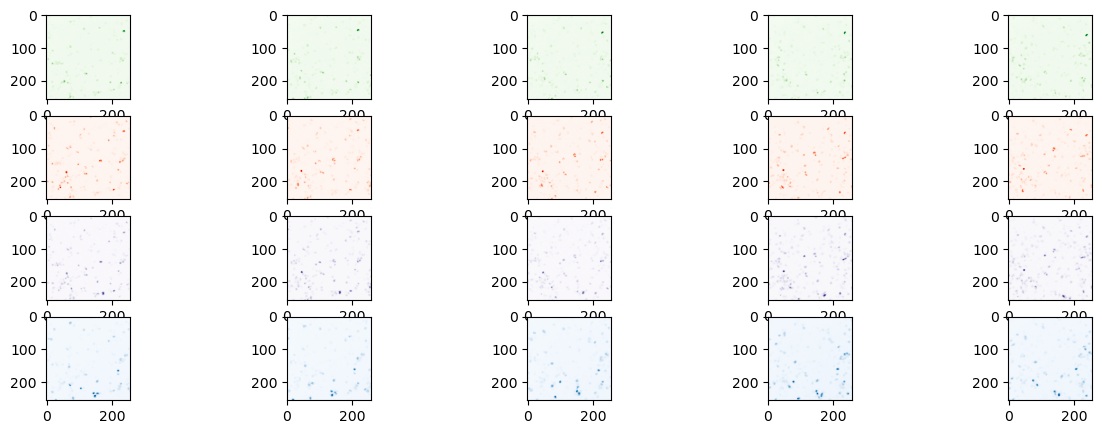

In [237]:
fig, ax = plt.subplots(4, 5, figsize=(15, 5))
for time in range(5):
    ax[0, time].imshow(image[time, :256, :256, 0], cmap="Greens")
    ax[1, time].imshow(image[time, :256, :256, 1], cmap="Reds")
    ax[2, time].imshow(image[time, :256, :256, 2], cmap="Purples")
    ax[3, time].imshow(image[time, :256, :256, 3], cmap="Blues")
plt.savefig(plots_path / f"raw_images.png", dpi=plot_dpi)

In [238]:
tracks_df = pd.read_pickle(tracks_path)

In [239]:
track_labels = np.load(track_label_path)

In [240]:
BLUE_FLAG = (image.shape[1] > 4)

In [241]:
tracks_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2
id,,,,,,,,,,
3000002,1,2,3.0,295.0,3000002,-1,-1,0.517573,0.182058,0.300369
4000006,1,3,4.0,294.0,4000006,-1,3000002,0.456241,0.239598,0.304161
5000010,1,4,6.0,298.0,5000010,-1,4000006,0.412807,0.264599,0.322594
6000025,1,5,11.0,293.0,6000025,-1,5000010,0.407295,0.256750,0.335956
7000018,7626,6,9.0,293.0,7000018,-1,-1,0.142763,0.366678,0.490560
8000050,7627,7,18.0,293.0,8000050,-1,-1,0.490679,0.201802,0.307519
9000048,7628,8,17.0,293.0,9000048,-1,-1,0.135081,0.373503,0.491416
10000057,7629,9,21.0,284.0,10000057,-1,-1,0.338295,0.190122,0.471583
11000062,7629,10,29.0,289.0,11000062,-1,10000057,0.438454,0.197716,0.363830


In [242]:
def invert_graph(graph):
    inverse_graph = {}
    for key, value in graph.items():
        if value in inverse_graph.keys():
            inverse_graph[value].append(key)
        else:
            inverse_graph[value] = [key]
    return inverse_graph

In [243]:
graph

{3: 2,
 4: 3,
 5: 3,
 6: 2,
 19: 18,
 21: 7662,
 22: 7662,
 23: 7666,
 24: 7666,
 26: 18,
 32: 7688,
 35: 7688,
 38: 37,
 39: 37,
 42: 39,
 43: 39,
 46: 7713,
 47: 46,
 48: 46,
 49: 48,
 50: 48,
 51: 7713,
 61: 7764,
 66: 7764,
 74: 7798,
 75: 74,
 80: 74,
 81: 7798,
 84: 7808,
 85: 7808,
 89: 7819,
 90: 89,
 91: 90,
 92: 90,
 93: 89,
 94: 7819,
 96: 7816,
 97: 7828,
 98: 7828,
 99: 7816,
 101: 7836,
 102: 101,
 103: 101,
 106: 7836,
 115: 114,
 120: 7882,
 121: 7882,
 124: 114,
 134: 133,
 135: 133,
 137: 7901,
 138: 7901,
 141: 7916,
 146: 7925,
 147: 7925,
 148: 7916,
 150: 149,
 151: 149,
 153: 152,
 163: 7951,
 164: 7951,
 166: 152,
 167: 166,
 168: 7955,
 169: 168,
 170: 168,
 171: 7955,
 172: 166,
 184: 7985,
 185: 7985,
 187: 7992,
 190: 7992,
 191: 190,
 192: 190,
 194: 193,
 197: 193,
 200: 199,
 203: 8028,
 204: 8028,
 210: 8054,
 217: 8054,
 223: 199,
 230: 8130,
 231: 8130,
 234: 8137,
 235: 8137,
 243: 8170,
 244: 8170,
 245: 8178,
 246: 8178,
 247: 246,
 248: 246,
 250: 

In [244]:
def get_lines(tracks_df, graph):
    all_tracks = tracks_df["track_id"].unique()

    igraph = invert_graph(graph)

    all_tracks = all_tracks[
        np.isin(all_tracks, np.array(list(graph.keys())), invert=True)
    ]

    def recurse_tracks(all_tracks, parent=None):
        for track_id in all_tracks:
            track = tracks_df[tracks_df["track_id"] == track_id]
            if parent is not None:
                track = pd.concat([parent, track])

            if track_id in igraph.keys():
                yield from recurse_tracks(igraph[track_id], track)
            else:
                yield track

    yield from recurse_tracks(all_tracks)

In [245]:
def get_single_line(track_id, tracks_df, graph):
    for track in get_lines(tracks_df, graph):
        if track_id in track["track_id"].values:
            return track

In [246]:
len(tracks_df)

203896

In [247]:
def populate_cell_intensities(image, track_labels, tracks_df):
    """Get the mean of the intensity of each channel for each track.

    Args:
            image (np.ndarray): numpy array of the image of the shape
                    (time, channels, h, w)
            track_labels (np.ndarray): an numpy array of labels generated
                    by ultrack
            tracks_df (pd.DataFrame): tracks dataframe from ultracks analysis

    Returns:
            pd.DataFrame: tracks dataframe merged with average intensities for
                    each cell
    """
    columns = ["green_intensity", "red_intensity", "farred_intensity"]
    if BLUE_FLAG:
        columns.append("blue_intensity")
    intensities = pd.DataFrame(columns=columns, index=tracks_df.index)

    def compute_intensities(row):
        time = int(row["t"])

        track_mask = track_labels[time] == row["track_id"]
        inten_dict = {
            "green_intensity": np.mean(image[time, :, :, 0][track_mask]),
            "red_intensity": np.mean(image[time, :, :, 1][track_mask]),
            "farred_intensity": np.mean(image[time, :, :, 2][track_mask]),
        }
        if BLUE_FLAG:
            inten_dict["blue_intensity"] = np.mean(image[time, :, :, 3][track_mask])

        return pd.Series(inten_dict)

    intensities = tracks_df.progress_apply(compute_intensities, axis=1)

    tracks_df = pd.merge(tracks_df, intensities, left_index=True, right_index=True)

    return tracks_df

In [248]:
track_intensity_df = populate_cell_intensities(image, track_labels, tracks_df)

  0%|          | 0/203896 [00:00<?, ?it/s]

/Users/jg/miniforge3/envs/display/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/jg/miniforge3/envs/display/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [249]:
track_intensity_df.head(10)

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,,,,
3000002,1,2,3.0,295.0,3000002,-1,-1,0.517573,0.182058,0.300369,1047.049180,552.262295,654.688525,287.557377
4000006,1,3,4.0,294.0,4000006,-1,3000002,0.456241,0.239598,0.304161,1036.270270,506.081081,625.527027,288.175676
5000010,1,4,6.0,298.0,5000010,-1,4000006,0.412807,0.264599,0.322594,949.345679,491.185185,622.777778,276.456790
6000025,1,5,11.0,293.0,6000025,-1,5000010,0.407295,0.256750,0.335956,971.419753,540.740741,629.641975,282.839506
7000018,7626,6,9.0,293.0,7000018,-1,-1,0.142763,0.366678,0.490560,808.613333,823.333333,810.000000,302.320000
8000050,7627,7,18.0,293.0,8000050,-1,-1,0.490679,0.201802,0.307519,NaN,NaN,NaN,NaN
9000048,7628,8,17.0,293.0,9000048,-1,-1,0.135081,0.373503,0.491416,NaN,NaN,NaN,NaN
10000057,7629,9,21.0,284.0,10000057,-1,-1,0.338295,0.190122,0.471583,NaN,NaN,NaN,NaN
11000062,7629,10,29.0,289.0,11000062,-1,10000057,0.438454,0.197716,0.363830,NaN,NaN,NaN,NaN


In [250]:
i = 13 #12
for track in get_lines(track_intensity_df, graph):
    # i -= 1
    # if i == 0:
    # 	single_track = track
    # 	break
    if len(track["track_id"].unique()) > 3:
        i -= 1
        if i == 0:
            single_track = track
            break

In [251]:
single_track

,track_id,t,y,x,id,parent_track_id,parent_id,c_0,c_1,c_2,green_intensity,red_intensity,farred_intensity,blue_intensity
id,,,,,,,,,,,,,,
34000572,9239,33,162.0,440.0,34000572,-1,-1,0.066708,0.424449,0.508843,NaN,NaN,NaN,NaN
35000544,9239,34,158.0,437.0,35000544,-1,34000572,0.071299,0.335963,0.592738,NaN,NaN,NaN,NaN
36000547,724,35,149.0,435.0,36000547,9239,35000544,0.035407,0.360261,0.604331,708.394366,708.014085,864.619718,873.619718
37000584,724,36,153.0,433.0,37000584,9239,36000547,0.042973,0.317526,0.639502,675.520548,615.575342,830.150685,796.520548
38000596,724,37,156.0,428.0,38000596,9239,37000584,0.043509,0.377983,0.578509,668.298246,703.964912,892.614035,872.210526
39000596,724,38,159.0,423.0,39000596,9239,38000596,0.057852,0.300525,0.641623,690.500000,694.085714,874.000000,835.471429
40000606,724,39,164.0,431.0,40000606,9239,39000596,0.061105,0.314223,0.624672,669.609375,687.859375,849.406250,853.640625
41000614,725,40,157.0,437.0,41000614,724,40000606,0.032591,0.298402,0.669007,659.372881,744.271186,982.796610,923.135593
42000593,726,41,152.0,438.0,42000593,725,41000614,0.039580,0.315528,0.644891,663.822581,707.774194,868.483871,902.612903


In [252]:
def get_intensity_graph(single_intensity_track, smooth = None, normalize = True, relative=False):
    """Generates a line graph of the intensity of each channel. Also
    indicates when the track was split.
    Note: Normalized in relation with the single track.

    TODO: Implement the parameter normalize

    Args:
            single_intensity_track (pd.DataFrame): a subset of the
                    track_intensity_df which contains a single track line.
                    Must contain intensity columns.
    """
    global BLUE_FLAG
    time = single_intensity_track["t"]
    green_intensity = single_intensity_track["green_intensity"]
    green_intensity = (green_intensity - green_intensity.min()) / (
        green_intensity.max() - green_intensity.min()
    )
    red_intensity = single_intensity_track["red_intensity"]
    red_intensity = (red_intensity - red_intensity.min()) / (
        red_intensity.max() - red_intensity.min()
    )
    farred_intensity = single_intensity_track["farred_intensity"]
    farred_intensity = (farred_intensity - farred_intensity.min()) / (
        farred_intensity.max() - farred_intensity.min()
    )
    if BLUE_FLAG:
        blue_intensity = single_intensity_track["blue_intensity"]
        blue_intensity = (blue_intensity - blue_intensity.min()) / (
            blue_intensity.max() - blue_intensity.min()
        )

    separation_points = []
    lines = single_intensity_track["track_id"].unique()

    for line_idx in lines:
        line = single_intensity_track[single_intensity_track["track_id"] == line_idx]
        if line.iloc[0]["parent_id"] == -1:
            continue
        else:
            separation_points.append(min(line.t))

    fig = plt.figure(figsize=(15, 5))

    if relative:
        old_BLUE_FLAG = BLUE_FLAG
        BLUE_FLAG = False
        sum_intensity = green_intensity + red_intensity + farred_intensity
        if BLUE_FLAG:
            sum_intensity = sum_intensity + blue_intensity
        green_intensity = green_intensity / sum_intensity
        red_intensity = red_intensity / sum_intensity
        farred_intensity = farred_intensity / sum_intensity
        if BLUE_FLAG:
            blue_intensity = blue_intensity / sum_intensity

    if smooth is not None:
        green_intensity_smoothed = gaussian_filter1d(green_intensity, sigma=smooth)
        red_intensity_smoothed = gaussian_filter1d(red_intensity, sigma=smooth)
        farred_intensity_smoothed = gaussian_filter1d(farred_intensity, sigma=smooth)
        if BLUE_FLAG:
            blue_intensity_smoothed = gaussian_filter1d(blue_intensity, sigma=smooth)

        plt.plot(time, green_intensity_smoothed, color="green")
        plt.plot(time, red_intensity_smoothed, color="red")
        plt.plot(time, farred_intensity_smoothed, color="purple")
        if BLUE_FLAG:
            plt.plot(time, blue_intensity_smoothed, color="blue")
    
    plt.plot(time, green_intensity, alpha=0.2 if smooth else 1, label="Green", color="green")
    plt.plot(time, red_intensity, alpha=0.2 if smooth else 1, label="Red", color="red")
    plt.plot(time, farred_intensity, alpha=0.2 if smooth else 1, label="Far Red", color="purple")
    if BLUE_FLAG:
        plt.plot(time, blue_intensity, alpha=0.2 if smooth else 1, label="Blue", color="blue")
        
    plt.legend(['Green', 'Red', 'Far Red', 'Blue'])
    if not relative:
        top, bottom = plt.ylim()
        plt.vlines(
            separation_points,
            ymin=top,
            ymax=bottom,
            color="black",
        )
    else:
        BLUE_FLAG = old_BLUE_FLAG
    # plt.show()
    plt.savefig(plots_path / f"single_intensity_graph_relative-{relative}.png", dpi=plot_dpi)

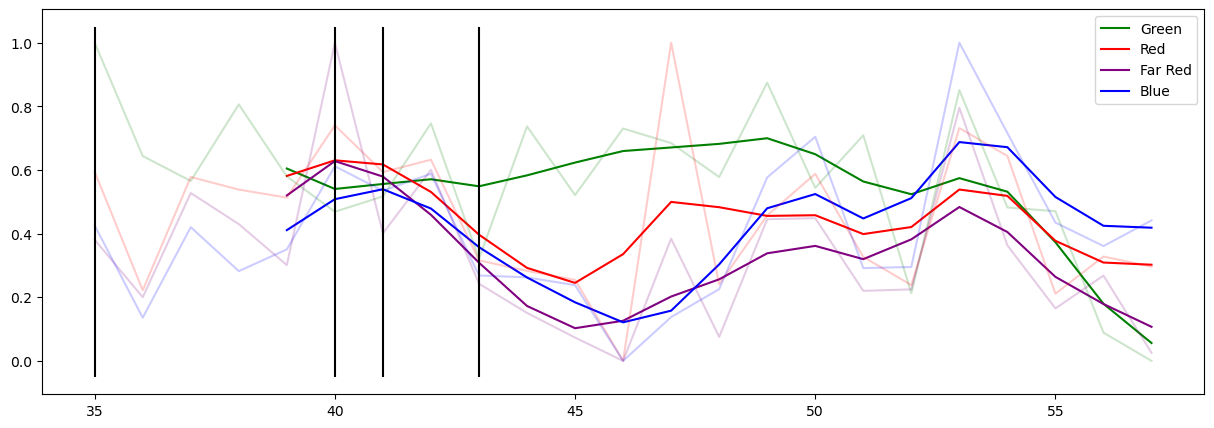

In [253]:
get_intensity_graph(single_track, smooth=1)

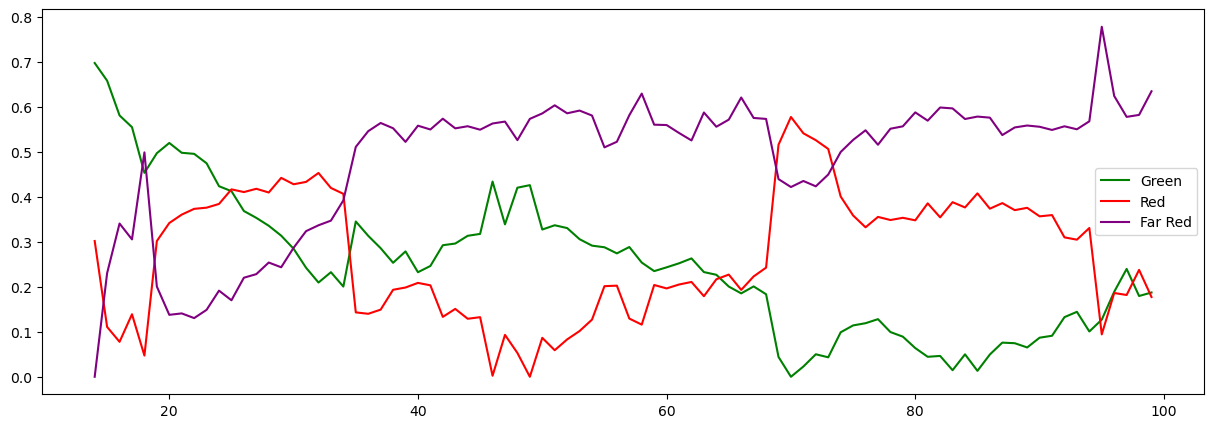

In [254]:
i = 38
#12, 30, 33, 38, 51
for track in get_lines(track_intensity_df, graph):
    # i -= 1
    # if i == 0:
    # 	single_track = track
    # 	break
    if len(track["track_id"].unique()) > 3:
        i -= 1
        if i == 0:
            single_track = track
            break
get_intensity_graph(single_track, smooth=None, relative=True)

In [255]:
def get_tracking_images(image, track_labels, single_track, padding=10):
    """Gets a list of images of each cell in the track
    for each channel.
    
    Args:
            image (np.ndarray): numpy array of the image of the
                    shape (time, channels, h, w)
            single_track (pd.DataFrame): a subset of tracks_df
                    containing a single track line.
    """
    channels = image.shape[3] + 1
    total_time = len(single_track)
    fig, ax = plt.subplots(channels, total_time, figsize=(15, 5))

    for cell in single_track.itertuples():
        time = cell.t

        track_mask_idx = np.where(track_labels[time] == cell.track_id)
        track_mask = (track_labels[time] == cell.track_id)
        xbounds = (track_mask_idx[0].min() - padding, track_mask_idx[0].max() + padding)
        xbounds = (int(max(0, xbounds[0])), int(min(image.shape[1], xbounds[1])))
        ybounds = (track_mask_idx[1].min() - padding, track_mask_idx[1].max() + padding)
        ybounds = (int(max(0, ybounds[0])), int(min(image.shape[2], ybounds[1])))

        ax[0][time].imshow(
            track_mask[xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]], cmap="gray"
        )
        ax[0][time].get_xaxis().set_visible(False)
        ax[0][time].get_yaxis().set_visible(False)
        ax[1][time].imshow(
            image[time, :, :, 0][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Greens",
        )
        ax[1][time].get_yaxis().set_visible(False)
        ax[1][time].get_xaxis().set_visible(False)
        ax[2][time].imshow(
            image[time, :, :, 1][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Reds",
        )
        ax[2][time].get_xaxis().set_visible(False)
        ax[2][time].get_yaxis().set_visible(False)
        ax[3][time].imshow(
            image[time, :, :, 2][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
            cmap="Purples",
        )
        ax[3][time].get_xaxis().set_visible(False)
        ax[3][time].get_yaxis().set_visible(False)
        if BLUE_FLAG:
            ax[4][time].imshow(
                image[time, :, :, 3][xbounds[0] : xbounds[1], ybounds[0] : ybounds[1]],
                cmap="Blues",
            )
            ax[4][time].get_xaxis().set_visible(False)
            ax[4][time].get_yaxis().set_visible(False)

    # plt.show()
    plt.savefig(plots_path / f"tracking_images.png", dpi=plot_dpi)

IndexError: index 86 is out of bounds for axis 0 with size 86

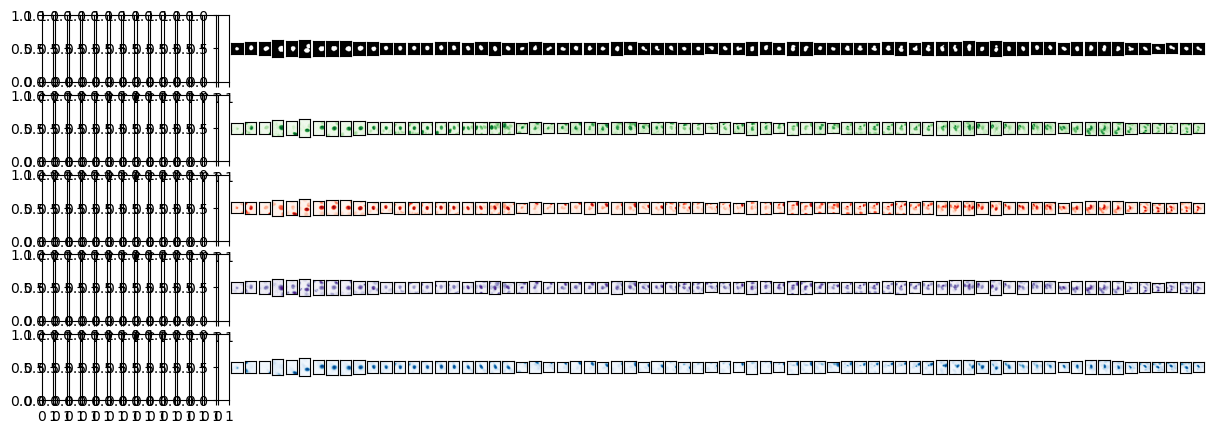

In [256]:
get_tracking_images(image, track_labels, single_track, padding=10)

In [257]:
def get_track_path_plot(single_intensity_track, smooth = None):

    def draw_single_track(x_channel, y_channel, ax):
        x_intensity = single_intensity_track[f"{x_channel}_intensity"]
        x_intensity = (x_intensity - x_intensity.min()) / (
            x_intensity.max() - x_intensity.min()
        )
        x_intensity = x_intensity.to_numpy()
        y_intensity = single_intensity_track[f"{y_channel}_intensity"]
        y_intensity = (y_intensity - y_intensity.min()) / (
            y_intensity.max() - y_intensity.min()
        )
        y_intensity = y_intensity.to_numpy()
        
        if smooth is not None:
            x_intensity = gaussian_filter1d(x_intensity, sigma=smooth)
            y_intensity = gaussian_filter1d(y_intensity, sigma=smooth)

        verts = []

        codes = []

        for i in range(len(single_intensity_track)):
            verts.append((x_intensity[i], y_intensity[i]))
            if i == 0:
                codes.append(mplPath.MOVETO)
            else:
                codes.append(mplPath.LINETO)

        path = mplPath(verts, codes)
        patch = patches.PathPatch(path, fill = False)
        ax.add_patch(patch)
        ax.set_xlabel(f"{x_channel.capitalize()} intensity")
        ax.set_ylabel(f"{y_channel.capitalize()} intensity")
        ax.scatter(x_intensity, y_intensity, color="black", s=5)
        offset = np.array([0.01, 0])
        ax.annotate("start", verts[0] + offset)
        ax.annotate("end", verts[-1] + offset)

    if not BLUE_FLAG:
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        draw_single_track("green", "red", ax[0][0])
        draw_single_track("green", "farred", ax[0][1])
        draw_single_track("red", "farred", ax[0][2])
    else:
        fig, ax = plt.subplots(2, 3, figsize=(15, 10))

        draw_single_track("green", "red", ax[0][0])
        draw_single_track("green", "farred", ax[0][1])
        draw_single_track("green", "blue", ax[0][2])
        draw_single_track("red", "farred", ax[1][0])
        draw_single_track("red", "blue", ax[1][1])
        draw_single_track("farred", "blue", ax[1][2])

    # plt.show()
    # plt.savefig(plots_path / f"channel_path_plot.png", dpi=plot_dpi)

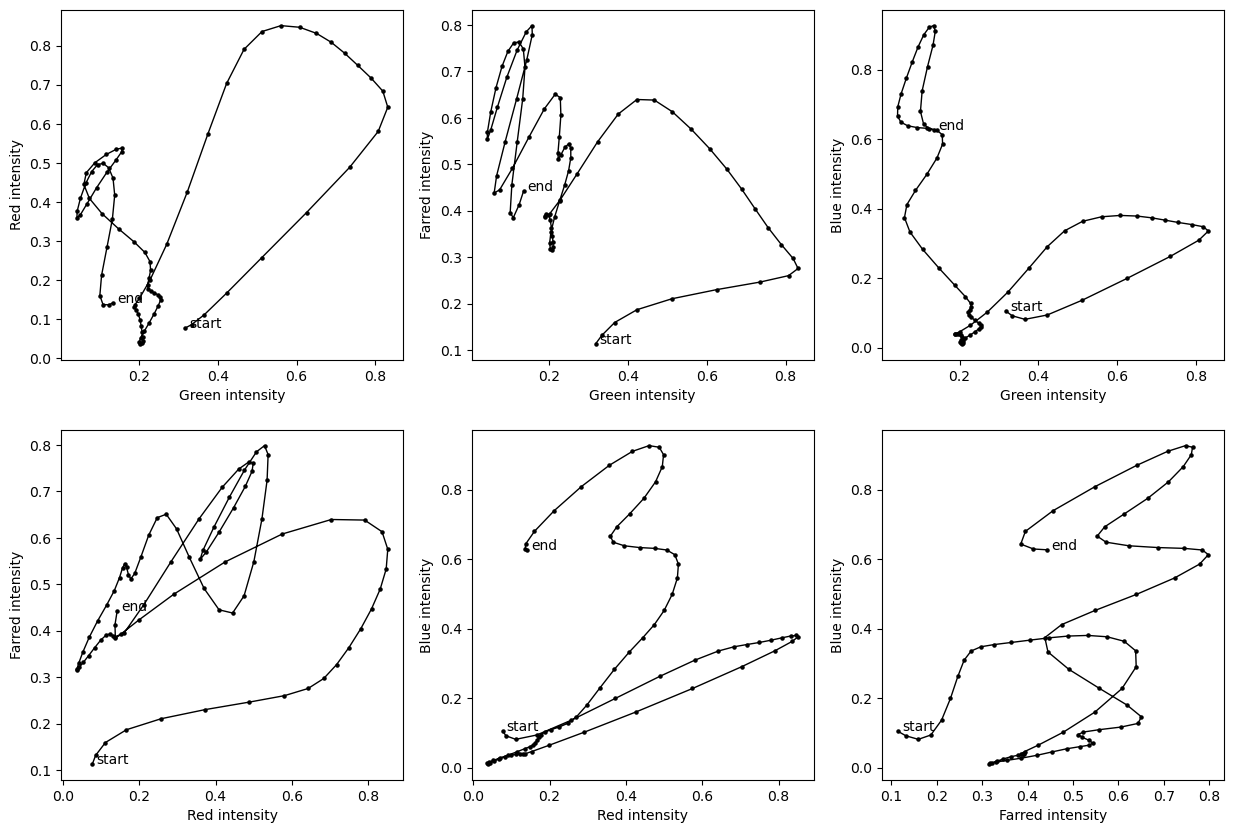

In [258]:
get_track_path_plot(single_track, smooth = 2)

In [259]:
def get_track_lengths(tracks_df, graph):
	for track in get_lines(tracks_df, graph):
		yield len(track)

In [260]:
def get_average_intensity_graph(tracks_df, graph):
    """Gets the plain average intensity aggregated over each time step.

    Args:
        tracks_df (pd.DataFrame): tracks dataframe from ultrack
        graph (dict): unused in this function, but kept for consistency
    """
    time_groups = tracks_df.groupby(by="t")

    tracks_df_means = time_groups.mean(numeric_only=True)
    tracks_df_std = time_groups.std(numeric_only=True)
    tracks_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        tracks_df_means.index,
        tracks_df_means["green_intensity"],
        label="Gree",
        color="green",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["green_intensity"]
        - Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        tracks_df_means["green_intensity"]
        + Z_SCORE
        * tracks_df_std["green_intensity"]
        / tracks_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["red_intensity"]
        - Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        tracks_df_means["red_intensity"]
        + Z_SCORE
        * tracks_df_std["red_intensity"]
        / tracks_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        tracks_df_means.index,
        tracks_df_means["farred_intensity"]
        - Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        tracks_df_means["farred_intensity"]
        + Z_SCORE
        * tracks_df_std["farred_intensity"]
        / tracks_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            tracks_df_means.index,
            tracks_df_means["blue_intensity"]
            - Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            tracks_df_means["blue_intensity"]
            + Z_SCORE
            * tracks_df_std["blue_intensity"]
            / tracks_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
    plt.legend()
    #limit plot on y axis:
    # plt.show()
    plt.savefig(plots_path / f"average_intensity_graph.png", dpi=plot_dpi)

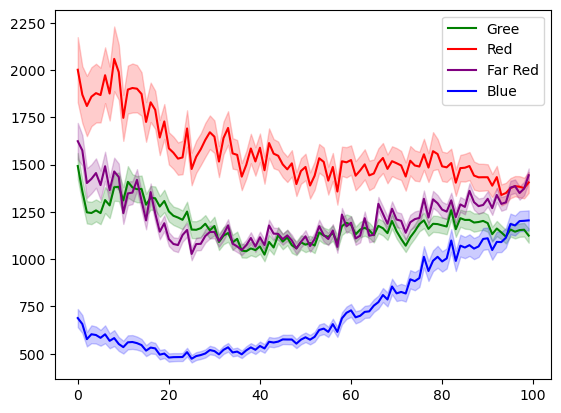

In [261]:
get_average_intensity_graph(track_intensity_df, graph)

In [262]:
def iterSample(iterable, samplesize):
    """Take sample from an iterable without replacement. 
    Taken from this post on StackOverflow: https://stackoverflow.com/a/12581484

    Args:
        iterable (iterator): iterator to sample from
        samplesize (int): sample size

    Raises:
        ValueError: Raises error if sample size is larger than population

    Returns:
        list: list of random samples
    """
    results = []

    for i, v in enumerate(iterable):
        r = random.randint(0, i)
        if r < samplesize:
            if i < samplesize:
                results.insert(r, v) # add first samplesize items in random order
            else:
                results[r] = v # at a decreasing rate, replace random items

    if len(results) < samplesize:
        raise ValueError("Sample larger than population.")

    return results

In [263]:
def get_offset_intensity_graphs(tracks_df, graph, sample_size = 3, normalize = True):
    """Generates graphs of intensity of individual tracks offset by the last split time for each track.

    TODO: Implement the parameter normalize

    Args:
        tracks_df (pd.DataFrame): tracks dataframe from ultrack
        graph (dict): hierarchy graph from ultrack
        sample_size (int, optional): number of tracks to plot. Defaults to 3.
    """
    random_tracks = iterSample(get_lines(tracks_df, graph), sample_size)
    last_split_time = 0
    
    fig, ax = plt.subplots(1, 4 if BLUE_FLAG else 3, figsize=(15, 5))

    for single_track in random_tracks:
        lines = single_track["track_id"].unique()

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if min(line.t) > last_split_time:
                last_split_time = min(line["t"])

        if last_split_time > 0:
            single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
        
        label = "\n+ ".join([str(x) for x in single_track["track_id"].unique()])

        ax[0].plot(single_track["t"], single_track["green_intensity"], label = label)
        ax[1].plot(single_track["t"], single_track["red_intensity"], label = label)
        ax[2].plot(single_track["t"], single_track["farred_intensity"], label = label)
        if BLUE_FLAG:
            ax[3].plot(single_track["t"], single_track["blue_intensity"], label = label)
        
        ax[0].set_title("Green Channel")
        ax[1].set_title("Red Channel")
        ax[2].set_title("Far Red Channel")
        if BLUE_FLAG:
            ax[3].set_title("Blue Channel")
    
    top, bottom = plt.ylim()
    for axis in ax:
        axis.vlines(
            0,
            ymin=top,
            ymax=bottom,
            color="black",
        )
        axis.set_xlim(left=-25)

    handles, labels = ax[-1].get_legend_handles_labels()
    print(handles, labels)
    fig.legend(handles, labels, loc='outside upper right')
    # plt.show()
    plt.savefig(plots_path / f"offset_intensity_graphs.png", dpi=plot_dpi)

[<matplotlib.lines.Line2D object at 0x12c9f85b0>, <matplotlib.lines.Line2D object at 0x12c9f97e0>, <matplotlib.lines.Line2D object at 0x12c9fa8c0>] ['17566', '12577\n+ 2425\n+ 2426', '20633']


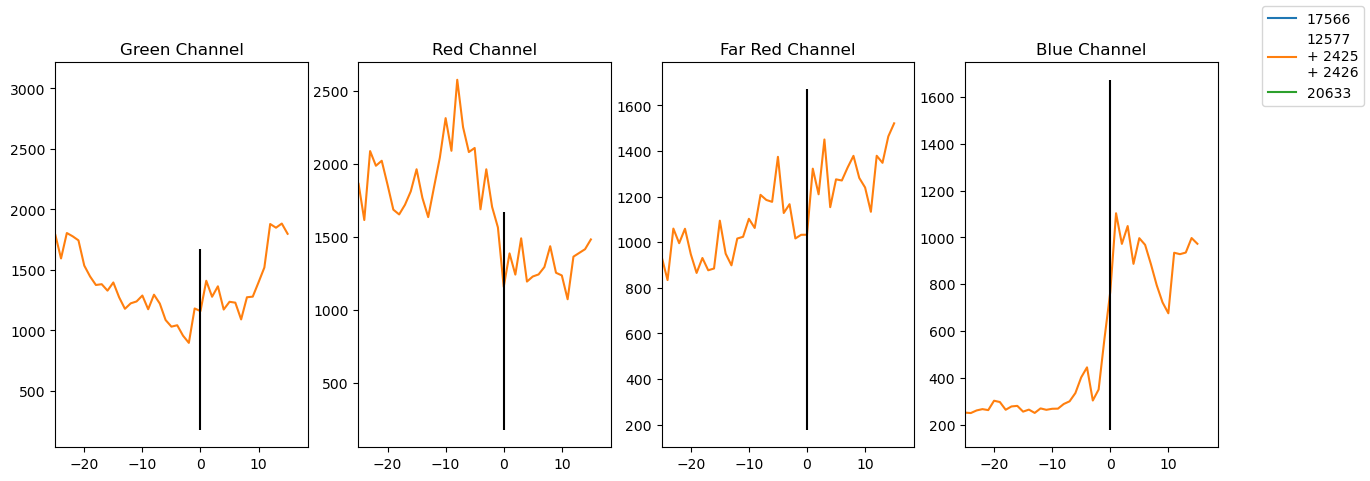

In [264]:
get_offset_intensity_graphs(track_intensity_df, graph)

In [267]:
def get_average_offset_intensity_graph(tracks_df, graph, normalize = True):
    """Get the average intensity over all tracks with time
            offset to the last split for each track.
        Intensities are normalized over their track.

        Skip the tracks which do not split.

        TODO: Implement the parameter normalize

    Args:
            tracks_df (pd.DataFrame): DataFrame of all tracks
            graph (dict): dictionary generated from ultrack
                    with track hiearchy.
    """
    offset_df = pd.DataFrame(columns=tracks_df.columns)
    for single_track in get_lines(tracks_df, graph):
        last_split_time = 0
        lines = single_track["track_id"].unique()

        single_track.loc[:, "green_intensity"] = (single_track["green_intensity"] - single_track["green_intensity"].min()) / (single_track["green_intensity"].max() - single_track["green_intensity"].min())
        single_track.loc[:, "red_intensity"] = (single_track["red_intensity"] - single_track["red_intensity"].min()) / (single_track["red_intensity"].max() - single_track["red_intensity"].min())
        single_track.loc[:, "farred_intensity"] = (single_track["farred_intensity"] - single_track["farred_intensity"].min()) / (single_track["farred_intensity"].max() - single_track["farred_intensity"].min())
        if BLUE_FLAG:
            single_track.loc[:, "blue_intensity"] = (single_track["blue_intensity"] - single_track["blue_intensity"].min()) / (single_track["blue_intensity"].max() - single_track["blue_intensity"].min())

        for line_idx in lines:
            line = single_track[single_track["track_id"] == line_idx]
            if min(line.t) > last_split_time:
                last_split_time = min(line["t"])

        if last_split_time > 0:
            single_track.loc[:, "t"] = single_track["t"].sub(last_split_time)
            offset_df = pd.concat([offset_df, single_track])

    time_groups = offset_df.groupby(by="t")

    offset_df_means = time_groups.mean(numeric_only=True)
    offset_df_std = time_groups.std(numeric_only=True)
    offset_df_len = time_groups.count()

    Z_SCORE = 1.96

    plt.plot(
        offset_df_means.index,
        offset_df_means["green_intensity"],
        label="Green",
        color="green",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["green_intensity"]
        - Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        offset_df_means["green_intensity"]
        + Z_SCORE
        * offset_df_std["green_intensity"]
        / offset_df_len["green_intensity"].pow(0.5),
        alpha=0.2,
        color="green",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["red_intensity"],
        label="Red",
        color="red",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["red_intensity"]
        - Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        offset_df_means["red_intensity"]
        + Z_SCORE
        * offset_df_std["red_intensity"]
        / offset_df_len["red_intensity"].pow(0.5),
        alpha=0.2,
        color="red",
    )
    plt.plot(
        offset_df_means.index,
        offset_df_means["farred_intensity"],
        label="Far Red",
        color="purple",
    )
    plt.fill_between(
        offset_df_means.index,
        offset_df_means["farred_intensity"]
        - Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        offset_df_means["farred_intensity"]
        + Z_SCORE
        * offset_df_std["farred_intensity"]
        / offset_df_len["farred_intensity"].pow(0.5),
        alpha=0.2,
        color="purple",
    )

    if BLUE_FLAG:
        plt.plot(
            offset_df_means.index,
            offset_df_means["blue_intensity"],
            label="Blue",
            color="blue",
        )
        plt.fill_between(
            offset_df_means.index,
            offset_df_means["blue_intensity"]
            - Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            offset_df_means["blue_intensity"]
            + Z_SCORE
            * offset_df_std["blue_intensity"]
            / offset_df_len["blue_intensity"].pow(0.5),
            alpha=0.2,
            color="blue",
        )
        
    top, bottom = plt.ylim()
    plt.vlines(
        0,
        ymin=top,
        ymax=bottom,
        color="black",
    )
    plt.legend()
    plt.xlim(left=-25, right=40)
    plt.ylim(top=0.8, bottom=0.0)

    # plt.show()
    plt.savefig(plots_path / f"average_offset_intensity_graph.png", dpi=plot_dpi)

/var/folders/fy/xrqtxc7d7xj4p71p4xs089s40000gn/T/ipykernel_45862/3025569806.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  offset_df = pd.concat([offset_df, single_track])


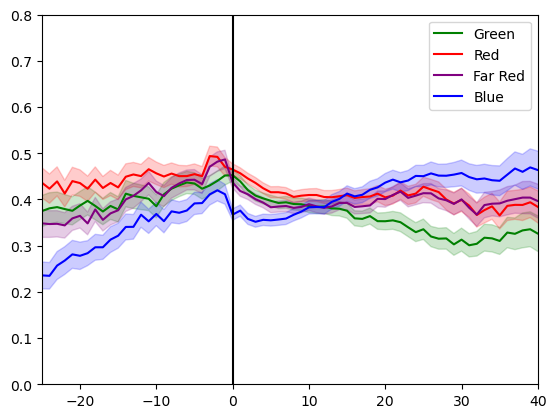

In [268]:
get_average_offset_intensity_graph(track_intensity_df, graph)

In [ ]:
last_line_lengths = []
for single_track in get_lines(tracks_df, graph):
	last_split_time = 0
	last_line_idx = single_track.iloc[0]["track_id"]
	lines = single_track.track_id.unique()

	for line_idx in lines:
		line = single_track[single_track["track_id"] == line_idx]
		if min(line.t) > last_split_time:
			last_split_time = min(line.t)
			last_line_idx = line_idx
	
	last_line = single_track[single_track["track_id"] == last_line_idx]
	if len(last_line) == 0:
		print(single_track)
	last_line_lengths.append(len(last_line))
plt.hist(last_line_lengths, bins=100)
# plt.show()
plt.savefig(plots_path / f"last_line_lengths.png", dpi=plot_dpi)

In [ ]:
min(last_line_lengths)